GLM: Linear regression

In [1]:
import arviz as az
# for convergence diagnostics, model checking and summaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import firedocks.pandas as pd
import xarray as xr
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.20.1


In [2]:
RANDOM_SEED = 8927
size = 200
true_intercept = 1
true_slope = 2


In [3]:
# Construct a new Generator with the default BitGenerator, to a wide range of distributions
rng = np.random.default_rng(seed=RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Generating data<br>

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [4]:
# np.linspace returns evenly spaced numbers over a specified interval.
x = np.linspace(start=0, stop=1, num=size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(loc=0.0, scale=0.5, size=size)
data = pd.DataFrame({"x": x, "y": y})

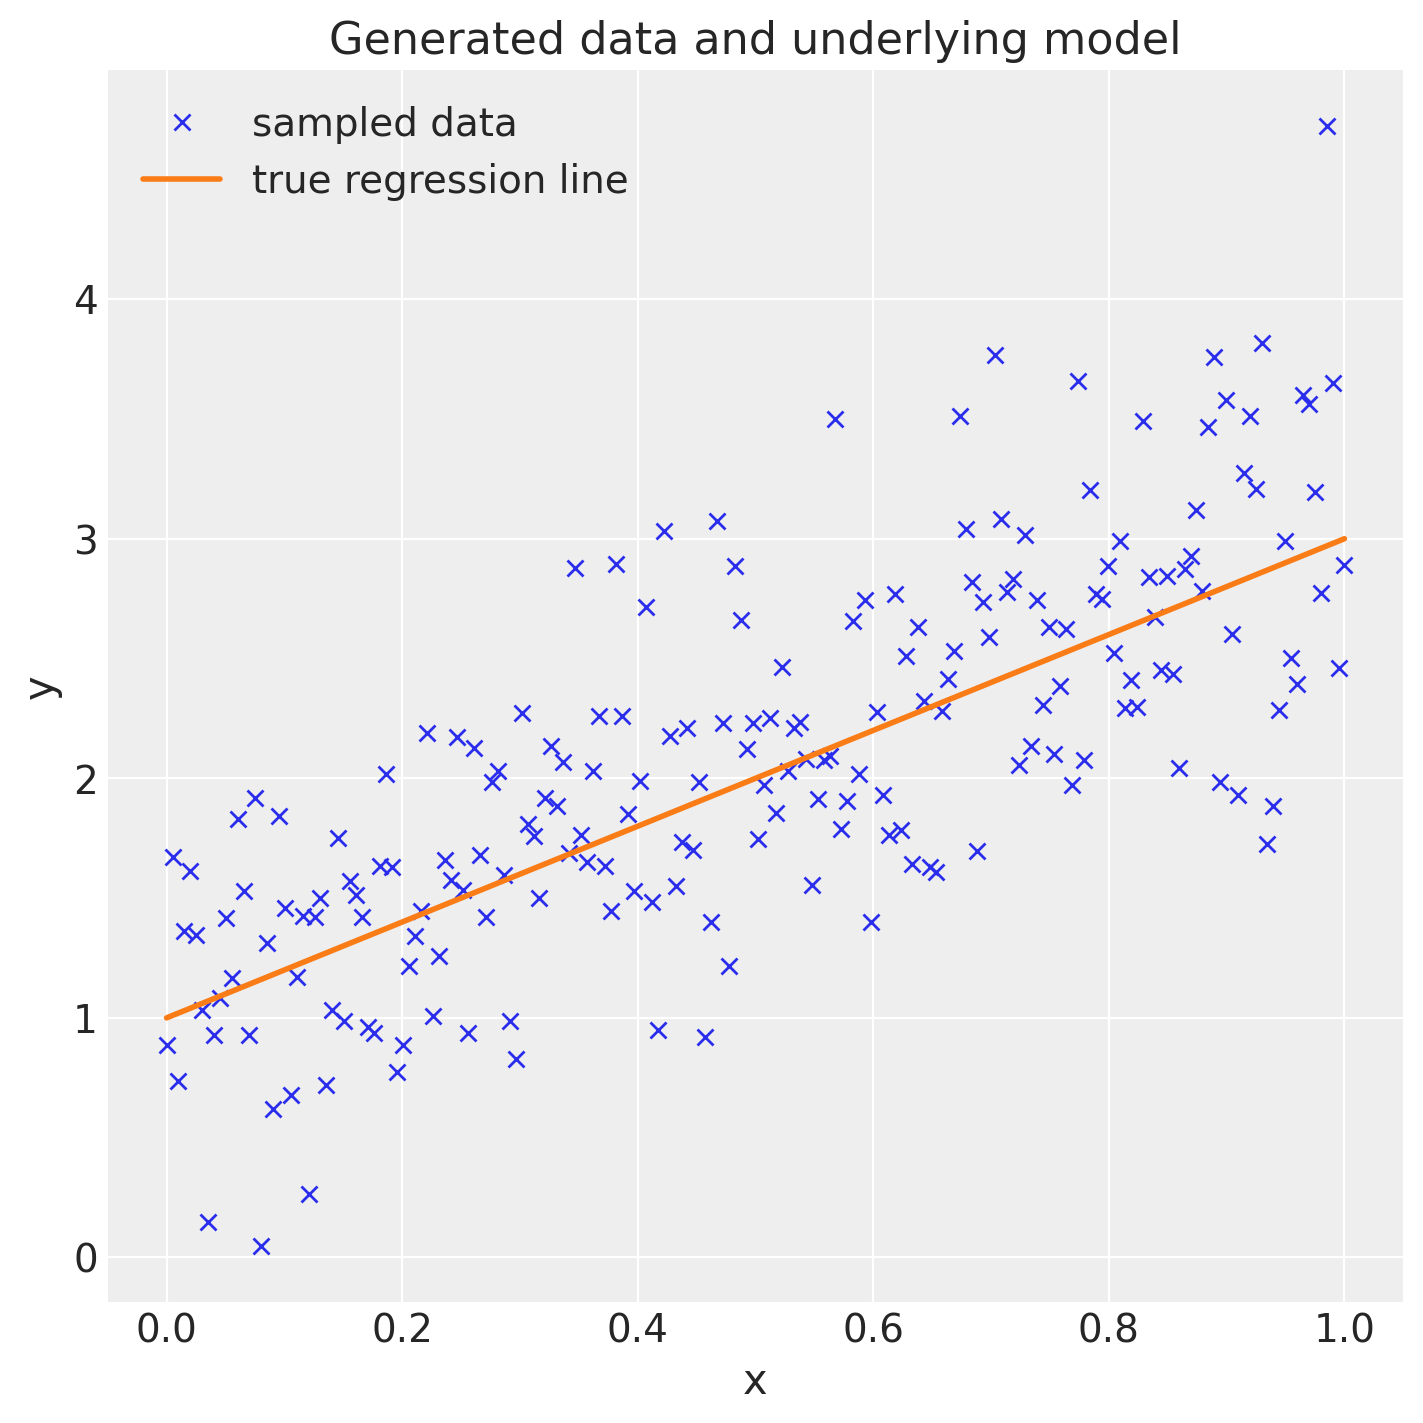

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [6]:
# with-statement or context manager, to specify a model object (container for variables and how they related to one another) 
# PyMc variables can not be defined without a corresponding Modle or they have to be put in the with model content.
with Model() as model:
    # Define priors
    sigma = HalfCauchy(name="sigma", beta=10)
    intercept = Normal(name="Intercept", mu=0, sigma=20)
    slope = Normal(name="slope", mu=0, sigma=20)

    # Define likelihood
    likelihood = Normal(name="y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


In [7]:
try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

In [8]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Initializing NUTS using jitter+adapt_diag...
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


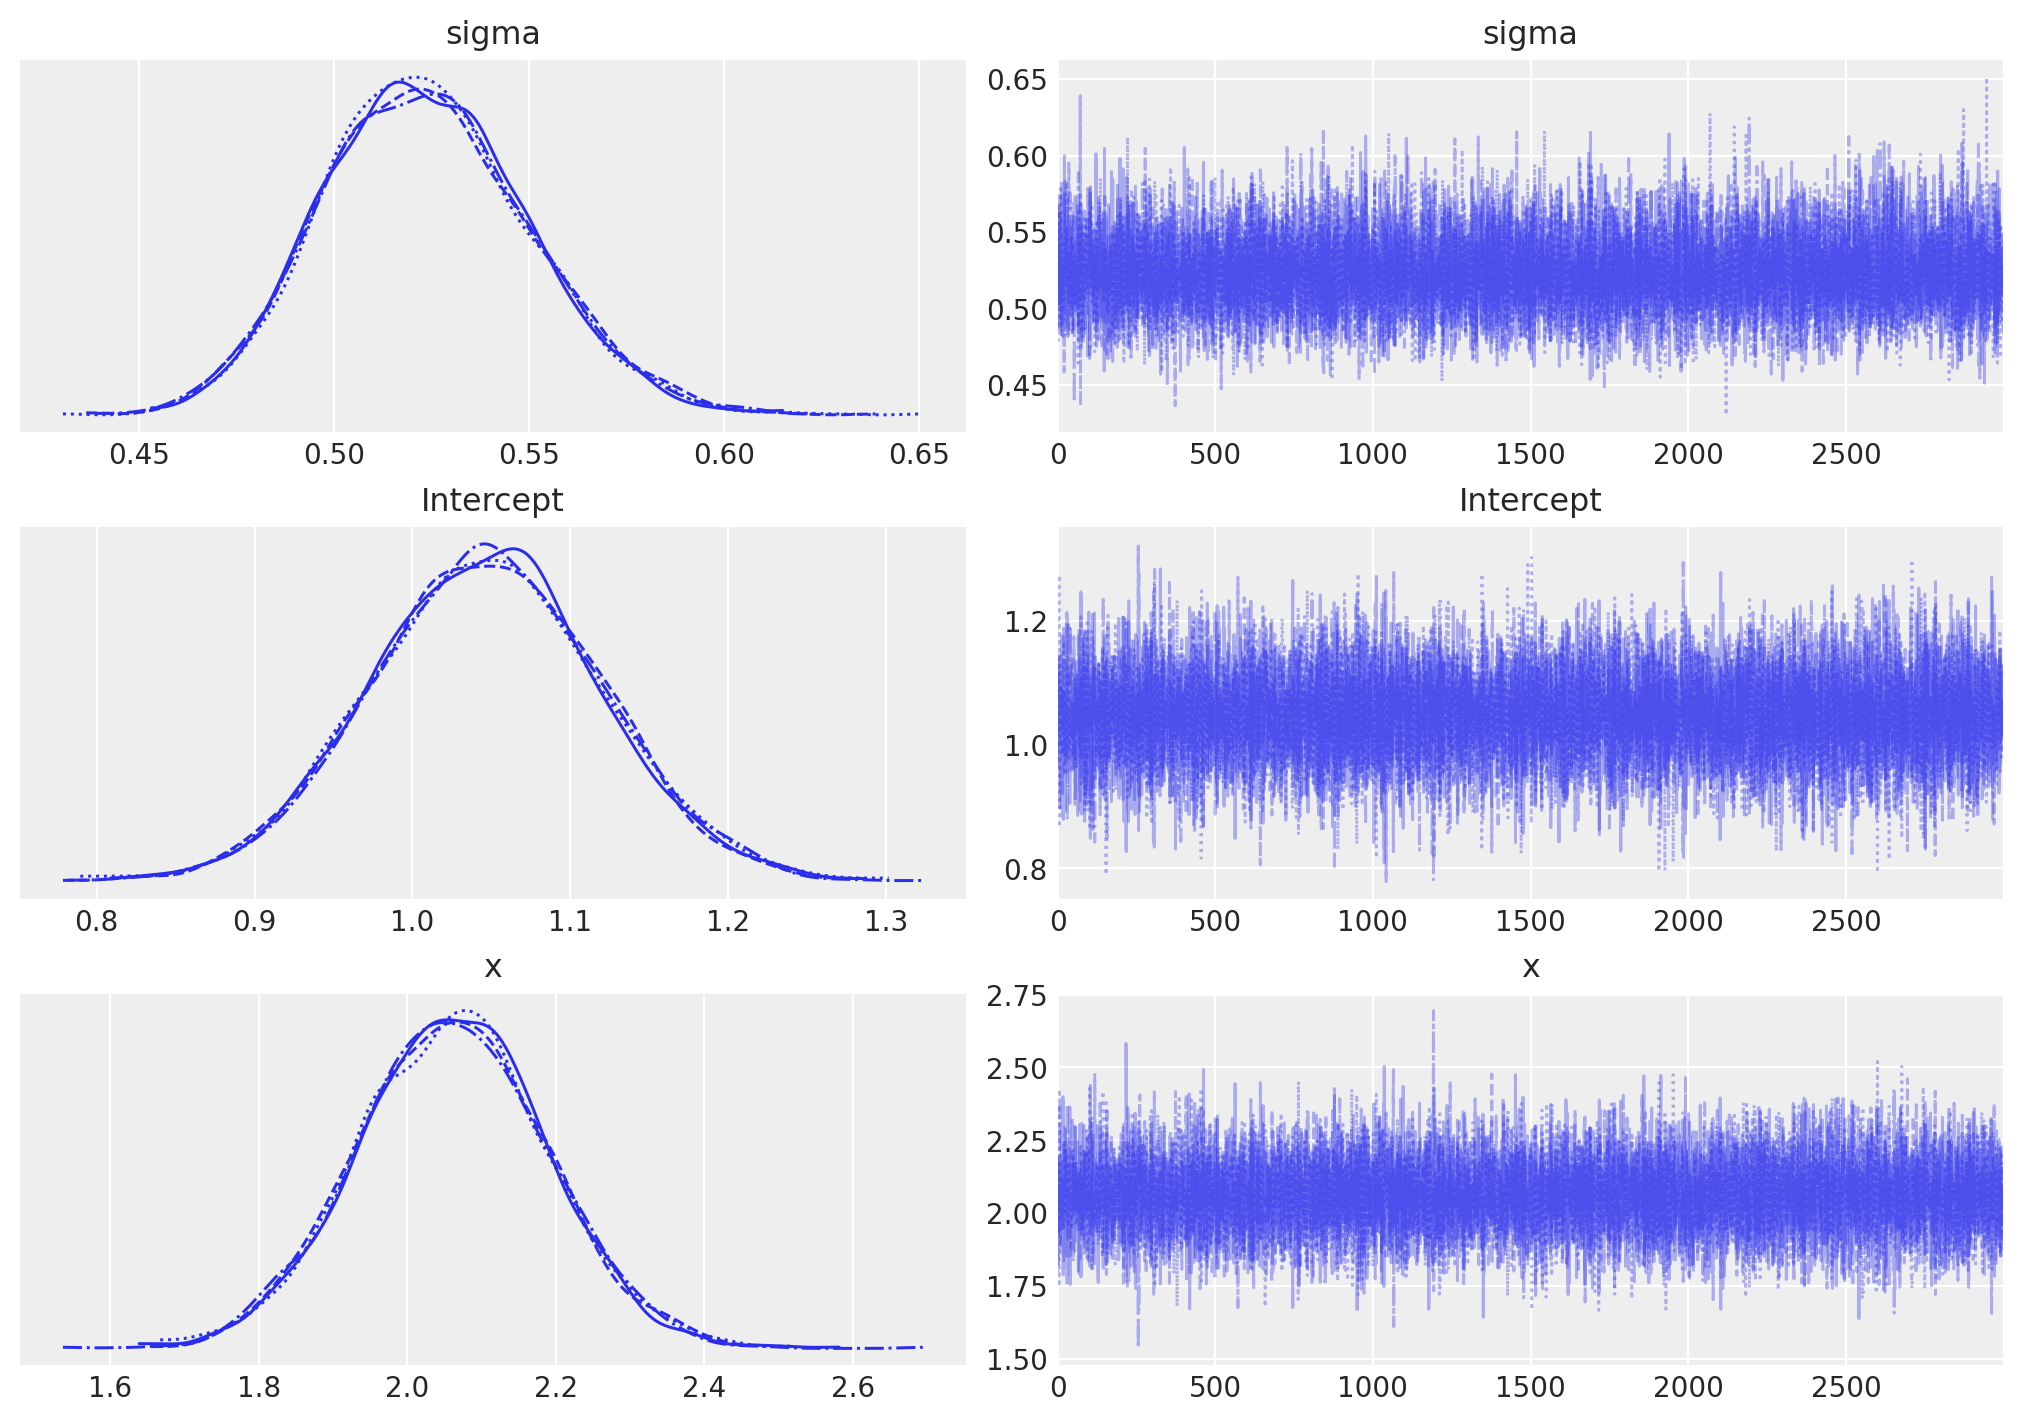

In [9]:
az.plot_trace(idata, figsize=(10, 7));

In [10]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


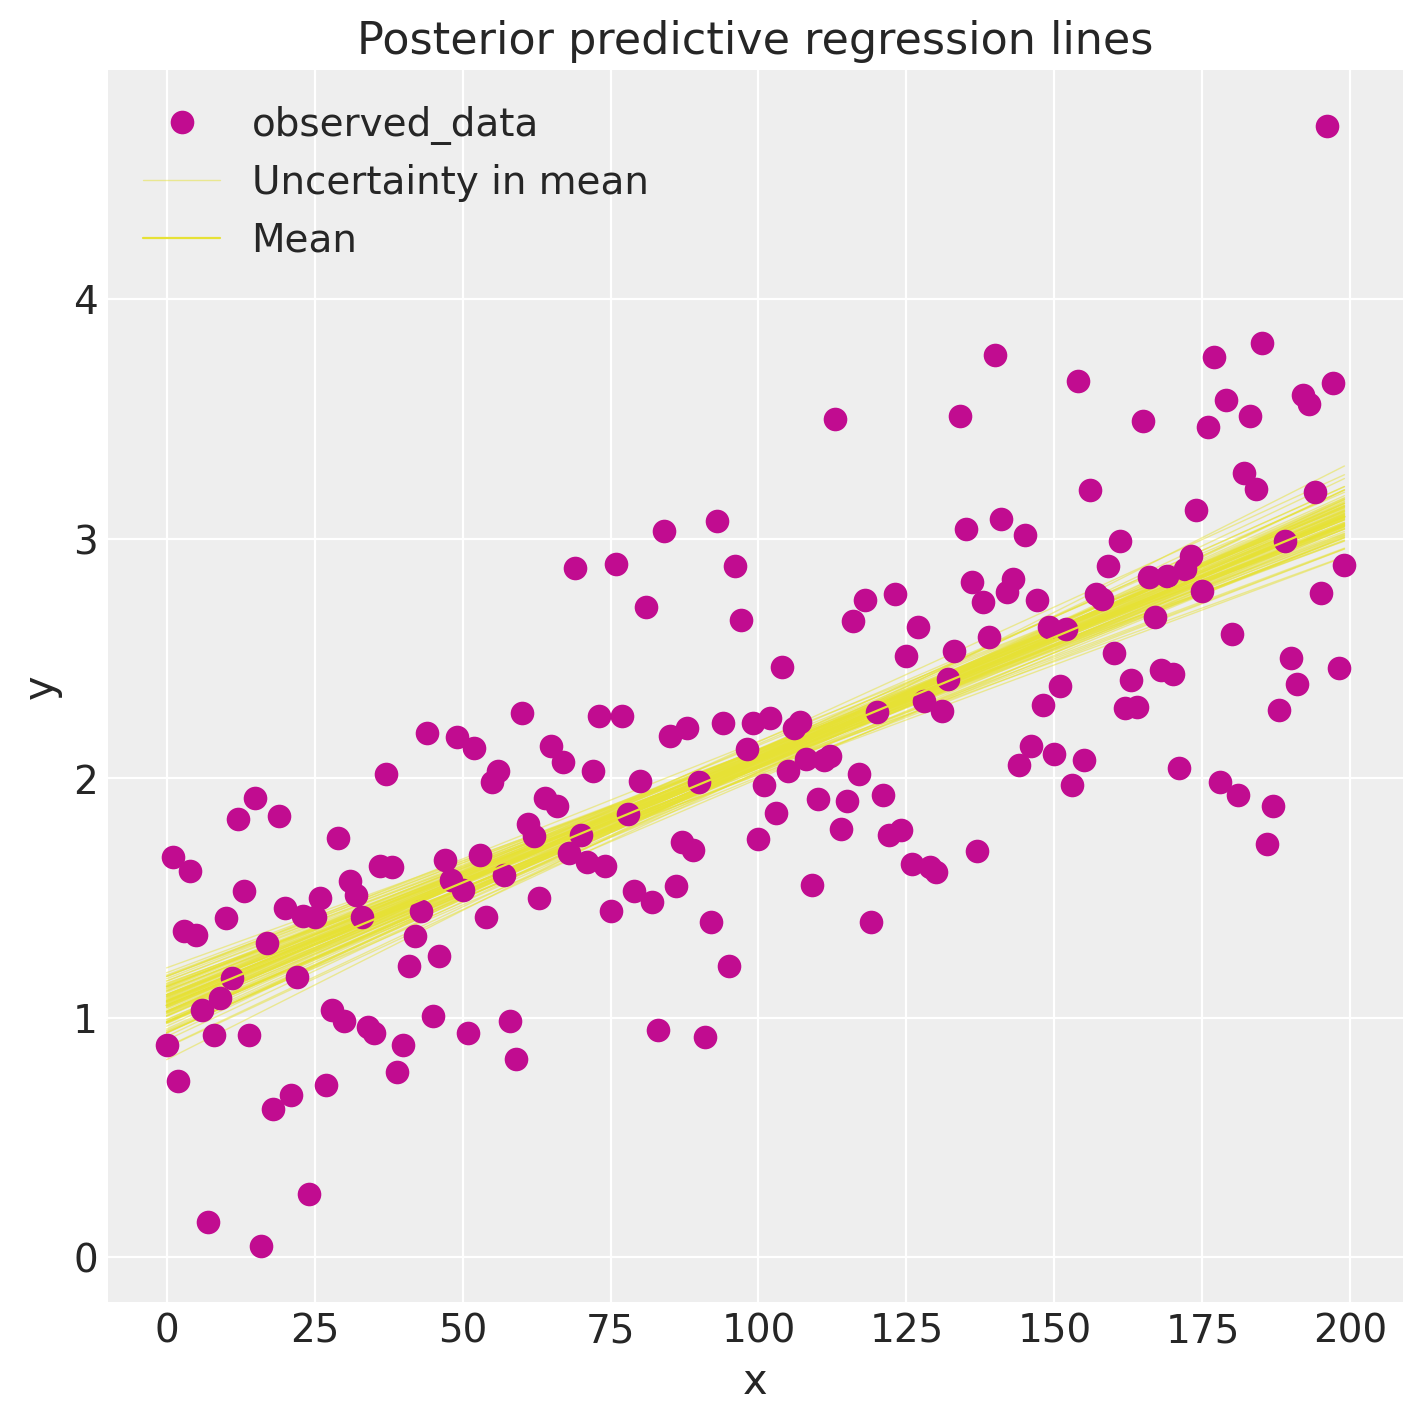

In [11]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");